In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import date2num
import mpl_finance as mpf
plt.rcParams['font.family'] = 'SimHei'

from local_utilities import load_as_df

In [2]:
stock_list = load_as_df('select * from base_stocks where market = "主板"')
stock_list = stock_list.set_index('ts_code')
code_list = list(stock_list.index)

s1,s2,s3,s4 = code_list[:500], code_list[500:1000], code_list[1000:1500], code_list[1500:]
ts_code = s1[0]

In [5]:
# 数据处理函数
def trade_days(ts_code, start_day='2019-01-01'):
    df_days = load_as_df('select * from tickers where ts_code = "{}" and trade_date >= "{}"'.format(ts_code, start_day))
    return df_days

def find_spec(ts_code, start_day='2019-01-01'):
    df_days = trade_days(ts_code, start_day)
    chg_times, vol_times = 0, 0
    try:
        if df_days.shape[0] > 0:
            spec_arr = pd.qcut(np.abs(df_days.pct_chg), 10, duplicates='drop').value_counts()
            bar_chg = spec_arr.keys()[0].left
            bar_vol = pd.qcut(np.abs(df_days.vol), 10).value_counts().keys()[0].left
            chg_times, vol_times = df_days[-10:][df_days.pct_chg > bar_chg].shape[0], df_days[-10:][df_days.vol > bar_vol].shape[0]
    except Exception as e:
        print('ts_code:{}, err:{}'.format(ts_code, e))
    return (ts_code, chg_times, vol_times)

In [3]:
# 绘图函数
def ana_candle_vol(ndays):
    _,ax = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
    # candle chart
    can_ax, vol_ax = ax[0], ax[1]
    can_ax.xaxis_date()
    can_ax.autoscale_view()
    d = date2num(ndays.index)
    ochl = zip(d, ndays.open, list(ndays.close), list(ndays.high), list(ndays.low))
    mpf.candlestick_ochl(can_ax,quotes=ochl,width=0.6, colorup='red',colordown='green', alpha=0.6)
    # bar chart
    vol_ax.bar(x=d, height=ndays.vol, alpha=0.7)
    vol_ax.xaxis_date()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

def ana_mc

In [6]:
spec_list = []
for s in s1:
    spec_list.append(find_spec(s))

In [7]:
df_spec = pd.DataFrame(spec_list, columns=('ts_code', 'chg_times', 'vol_times'))
df_spec = df_spec.set_index('ts_code')
df_spec = df_spec[(df_spec.chg_times > 2) & (df_spec.vol_times > 1)].sort_values(by='chg_times', ascending=False)
df_spec = df_spec.join(stock_list)

In [87]:
df_spec[:4]

,chg_times,vol_times,symbol,name,area,industry,market,list_date
ts_code,,,,,,,,
000573.SZ,8,3,000573,粤宏远A,广东,区域地产,主板,19940815
000751.SZ,8,3,000751,锌业股份,辽宁,铅锌,主板,19970626
000630.SZ,7,2,000630,铜陵有色,安徽,铜,主板,19961120
000521.SZ,7,5,000521,长虹美菱,安徽,家用电器,主板,19931018


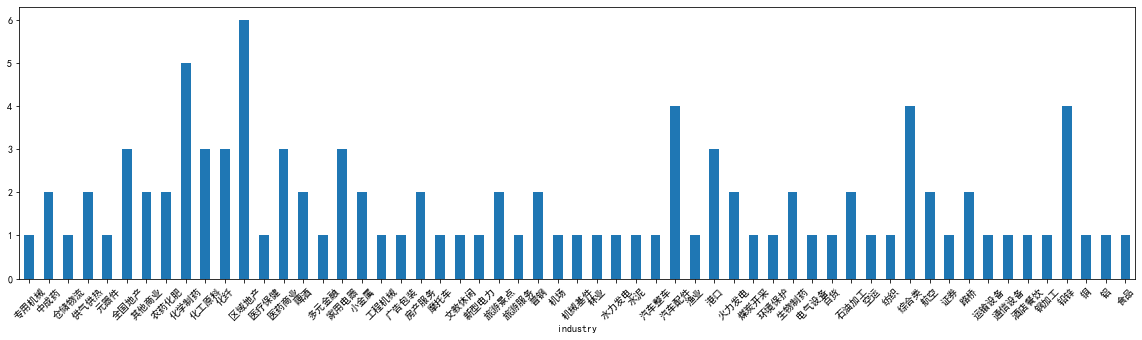

In [8]:
df_spec.groupby('industry', as_index=True).count()['symbol'].plot(kind='bar', figsize=(20,5))
plt.xticks(rotation=45)
plt.show()

In [32]:
df_all = pd.concat([df_spec,stock_list], axis=1)

Text(0, 0.5, 'price abnormal pct')

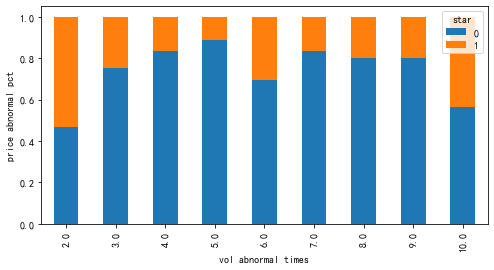

In [33]:
df_all[:4]
df_all['star'] = np.where(df_all.chg_times>5, 1, 0)
xt = pd.crosstab(df_all.vol_times, df_all.star )
xt_pct = xt.div(xt.sum(1).astype(float), axis=0)
xt_pct.plot(kind='bar', stacked=True, figsize=(8,4))
plt.xlabel('vol abnormal times')
plt.ylabel('price abnormal pct')

In [23]:
def load_tickers(ts_code, start_day='2019-01-01'):
    tf_trend = load_as_df('select * from tickers where ts_code = "{}" and trade_date >= "{}"'.format(ts_code, start_day))
    tf_trend = tf_trend.set_index('trade_date')
    return tf_trend

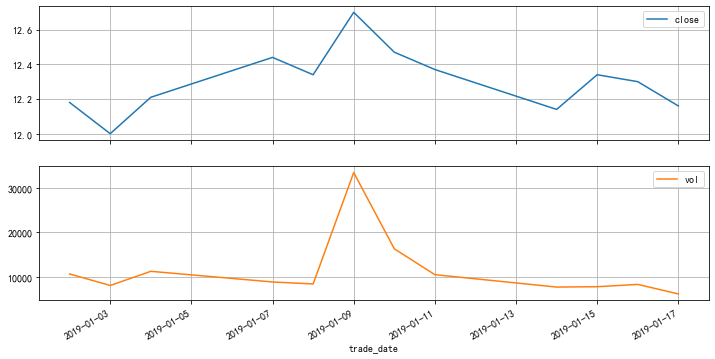

In [24]:
load_tickers('000411.SZ')[:12][['close','vol']].plot(subplots=True, grid=True, layout=(2,1), figsize=(12,6))
plt.show()

In [9]:
# bins = [-np.inf, 60, 80, 100, np.inf]
# pd.cut(np.arange(1000)%100,bins=bins).value_counts()

tdays = trade_days(ts_code='000411.SZ')
tdays = tdays.set_index('trade_date')
tchgs = pd.qcut(np.abs(tdays.pct_chg), 5)

In [8]:
pd.get_dummies(tchgs)

,"(-0.001, 0.413]","(0.413, 0.845]","(0.845, 1.492]","(1.492, 2.538]","(2.538, 10.014]"
trade_date,,,,,
2019-01-02,0,0,0,0,1
2019-01-03,0,0,1,0,0
2019-01-04,0,0,0,1,0
2019-01-07,0,0,0,1,0
2019-01-08,0,1,0,0,0
...,...,...,...,...,...
2020-07-27,0,0,0,0,1
2020-07-28,0,0,0,0,1
2020-07-29,0,0,0,0,1


In [26]:
import seaborn as sb

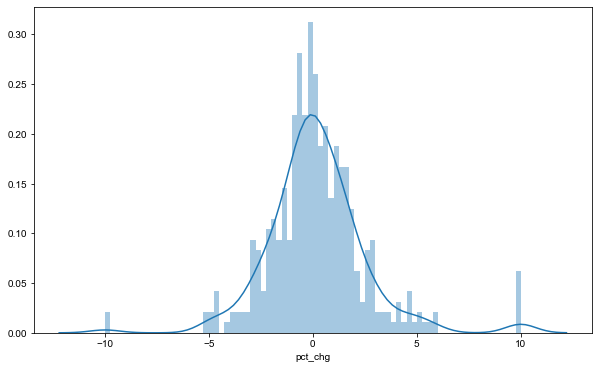

In [34]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(10,6))
sb.distplot(tdays.pct_chg, bins=80)
plt.show()

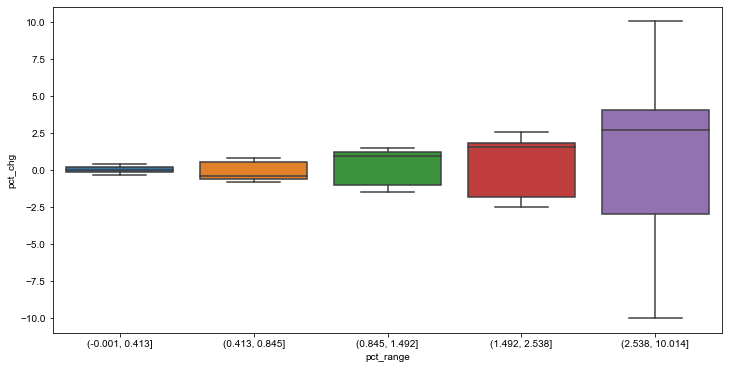

In [28]:
plt.figure(figsize=(12, 6))
p1 = tchgs.rename('pct_range')
p2 = pd.DataFrame(p1)
p3 = tdays.join(p2)
sb.boxplot(x='pct_range', y='pct_chg', data=p3)
plt.show()

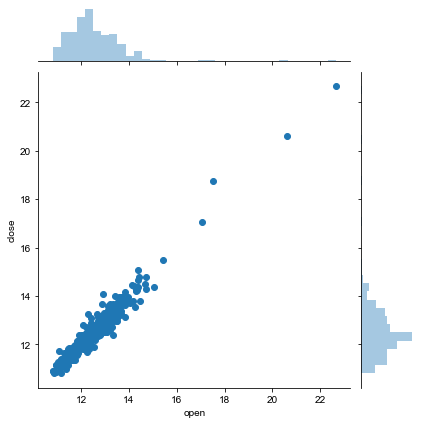

In [29]:
sb.jointplot(tdays.open, np.abs(tdays.close))
plt.show()

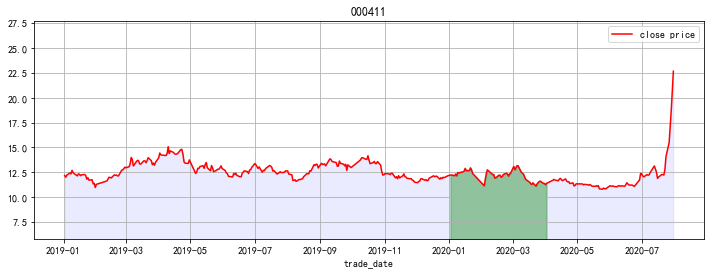

In [10]:
t1 = pd.to_datetime('2020-01-02').date()
t2 = pd.to_datetime('2020-04-02').date()

tdays.close.plot(figsize=(12,4),c='r',grid=True)
plt.fill_between(tdays.index, 0, tdays.close, color='blue', alpha=.08)
plt.fill_between(tdays[t1:t2].index, tdays[t1:t2].close, color='green', alpha=.38)

plt.ylim(np.min(tdays.close) - 5, np.max(tdays.close) + 5)
plt.legend(['close price'], loc='best')
plt.title('000411')
# plt.annotate('sell for profit', xy=)
plt.show()

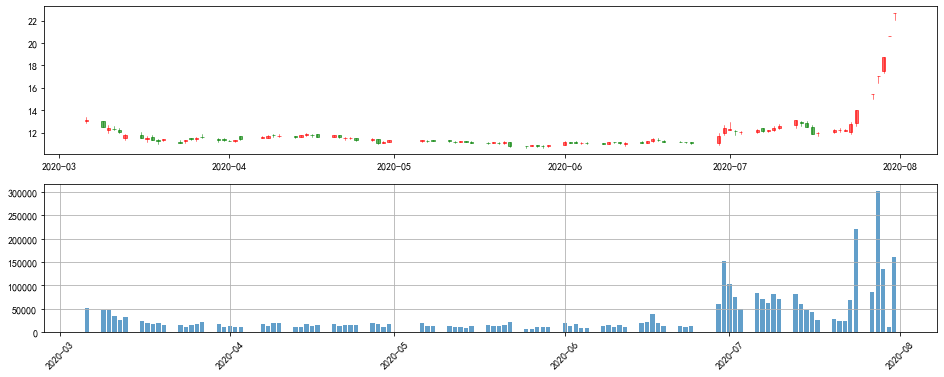

In [11]:
ana_candle_vol(tdays[-100:])

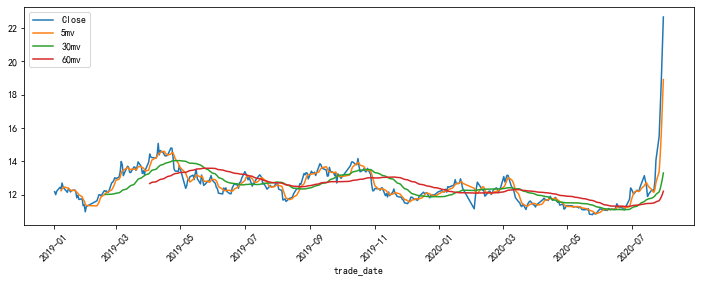

In [12]:
# 均线
tdays.close.plot(figsize=(12,4))
tdays.close.rolling(window=5).mean().plot()
tdays.close.rolling(window=30).mean().plot()
tdays.close.rolling(window=60).mean().plot()
plt.legend(['Close', '5mv', '30mv', '60mv'], loc='best')
plt.xticks(rotation=45)
plt.show()

In [81]:
# tdays[(tdays.close - tdays.open > 0) & (tdays.keys<len(tdays))]
# len(tdays)
# tdays.shape[0]
ndays = tdays.copy().reset_index()
x = ndays[:-1][ndays.close - ndays.open > 0].index
ndays.iloc[x+1].change.map(lambda x: 1 if x>0 else 0).sum()
ndays.iloc[x+1].change.map(lambda x: 1 if x<=0 else 0).sum()

101

In [13]:
# ndays.iloc[x][:5]

days_a = trade_days(ts_code='000630.SZ')
days_a = days_a.set_index('trade_date')
days_b = trade_days(ts_code='000751.SZ')
days_b = days_b.set_index('trade_date')

In [99]:
days_a

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2019-01-02,000630.SZ,1.97,1.98,1.95,1.95,1.97,-0.02,-1.0152,155993.21,30621.842
2019-01-03,000630.SZ,1.96,1.97,1.95,1.96,1.95,0.01,0.5128,173642.18,34055.920
2019-01-04,000630.SZ,1.95,2.00,1.94,2.00,1.96,0.04,2.0408,321803.09,63655.059
2019-01-07,000630.SZ,2.01,2.04,2.00,2.03,2.00,0.03,1.5000,416079.80,84004.327
2019-01-08,000630.SZ,2.02,2.03,2.00,2.02,2.03,-0.01,-0.4926,268829.71,54130.150
...,...,...,...,...,...,...,...,...,...,...
2020-07-27,000630.SZ,2.19,2.24,2.15,2.22,2.16,0.06,2.7778,1128923.63,248879.662
2020-07-28,000630.SZ,2.28,2.33,2.24,2.26,2.22,0.04,1.8018,1876207.81,428810.094
2020-07-29,000630.SZ,2.24,2.26,2.19,2.26,2.26,0.00,0.0000,1113434.23,247911.666


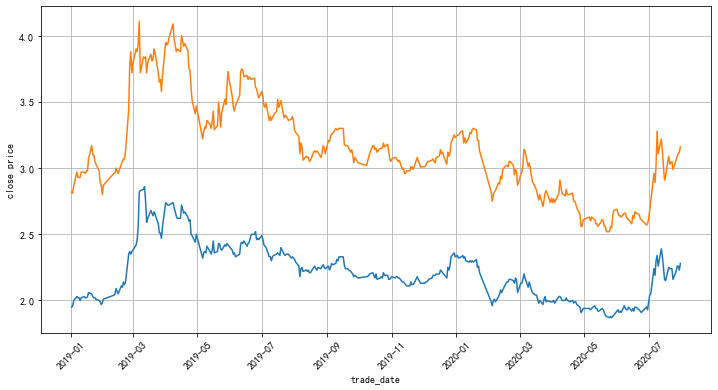

In [108]:
days_a.close.plot(figsize=(12,6))
days_b.close.plot()
plt.xticks(rotation=45)
plt.grid(True)
plt.ylabel('close price')
plt.show()

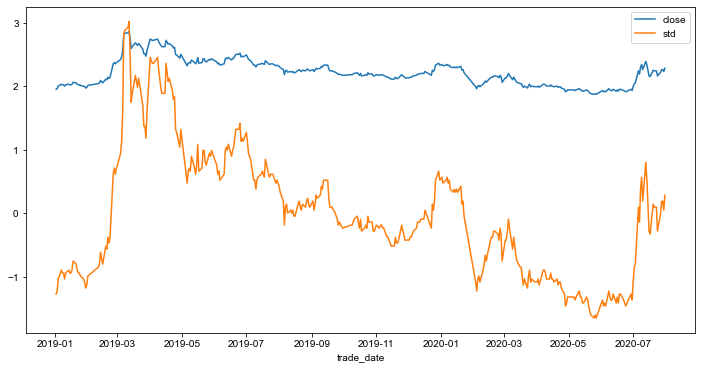

In [137]:
# days_a.close.mean()
plt.rcParams['font.family'] = 'Arial'
def regular_std(s):
    return (s - s.mean())/s.std()

days_a.close.plot(figsize=(12, 6))
regular_std(days_a.close).plot()
plt.legend(['close','std'])
plt.show()

In [145]:
from scipy import stats
a_618 = stats.scoreatpercentile(days_a.close, 61.8)
a_382 = stats.scoreatpercentile(days_a.close, 38.2)


In [121]:
(days_a.close.max() - days_a.close.min()) * 0.618 + days_a.close.min()

2.48182

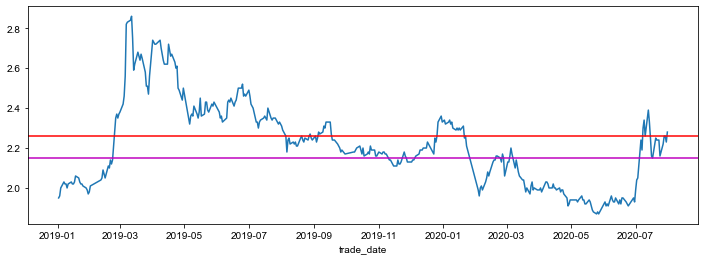

In [152]:
days_a.close.plot(figsize=(12, 4))
plt.axhline(a_618, c='r')
plt.axhline(a_382, c='m')
# plt.fill_between(days_a.index, a_382, a_618, color='r')
plt.show()

In [15]:
import talib

In [16]:
dif, dea, bar = talib.MACD(days_a.close.values, fastperiod=12, slowperiod=26, signalperiod=9)

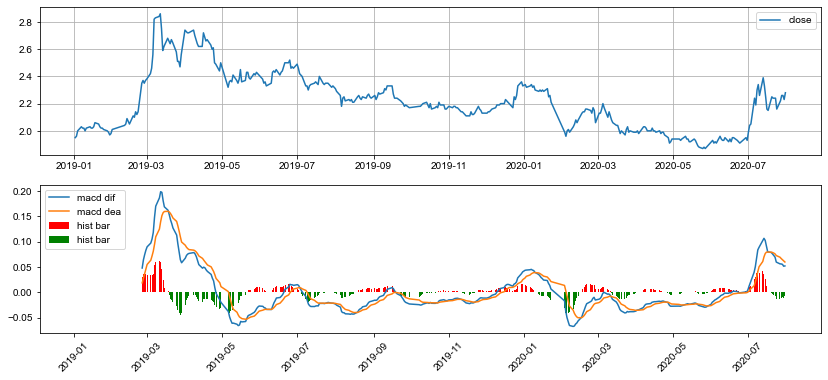

In [36]:
plt.rcParams['font.family'] = 'Arial'
_, subplots = plt.subplots(nrows=2, ncols=1, figsize=(14,6))
subplots[0].plot(days_a.close, label='close')
subplots[0].legend(loc='best')
subplots[0].grid(True)
subplots[1].plot(days_a.index, dif, label='macd dif')
subplots[1].plot(days_a.index, dea, label='macd dea')
bar_red = np.where(bar > 0, bar, 0)
bar_green = np.where(bar <0, bar, 0)
subplots[1].bar(days_a.index, bar_red, facecolor='red', label='hist bar')
subplots[1].bar(days_a.index, bar_green, facecolor='green', label='hist bar')
subplots[1].legend(loc='best')
plt.xticks(rotation=45)
plt.show()